In [1]:

import os.path as osp
shared_folder = osp.abspath(osp.join('..', 'share')); assert osp.exists(shared_folder)
import sys
if shared_folder not in sys.path: sys.path.insert(1, shared_folder)
from notebook_utils import NotebookUtilities
nu = NotebookUtilities(
    data_folder_path=osp.abspath(osp.join('..', 'data')),
    saves_folder_path=osp.abspath(osp.join('..', 'saves'))
)

# Import needed libraries
%pprint
sys.path.insert(1, osp.join('..', 'py'))

from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import textwrap
import warnings

# Turn off warnings
warnings.filterwarnings('ignore')

Pretty printing has been turned OFF


In [2]:

generations_df = nu.load_object('generations_df')
turning_numbers_df = nu.load_object('turning_numbers_df')
turnings_df = nu.load_object('turnings_df')

In [3]:

# nu.get_dir_tree('NotebookUtilities', contains_str=None, not_contains_str=None)


# English and British Monarchs

In [5]:

if nu.pickle_exists('english_and_british_monarchs_df'):
    english_and_british_monarchs_df = nu.load_object('english_and_british_monarchs_df')
else:
    english_and_british_monarchs_df = nu.load_csv('List_of_English_and_British_monarchs')
    import wikipedia
    from bs4 import BeautifulSoup as bs
    for row_index, row_series in english_and_british_monarchs_df.iterrows():
        monarch_name = row_series.monarch_name
        wikipedia_url = row_series.wikipedia_url
        try:
            page_obj = wikipedia.page(title=monarch_name)
            page_html = page_obj.html()
            page_soup = bs(page_html, 'html.parser')
        except:
            page_soup = nu.get_page_soup(wikipedia_url, verbose=False)
        
        # Get the birth year
        try:
            for th_soup in page_soup.find_all(
                name='th',
                attrs={'scope': 'row', 'class': 'infobox-label'},
                recursive=True,
                text='Born'
            ):
                td_soup = th_soup.find_next_sibling(name='td', attrs={'class': 'infobox-data'})
                year_of_birth = nu.get_first_year_element(' '.join(list(td_soup.stripped_strings)))
                english_and_british_monarchs_df.loc[row_index, 'year_of_birth'] = year_of_birth
        except:
            tables_df_list = nu.get_page_tables(wikipedia_url, verbose=False)
            df = tables_df_list[0].copy()
            mask_series = (df.iloc[:, 0] == 'Born')
            year_of_birth = nu.get_first_year_element(df[mask_series].iloc[:, 1].squeeze())
            english_and_british_monarchs_df.loc[row_index, 'year_of_birth'] = year_of_birth
        
        # Get the death year
        year_of_death = np.nan
        try:
            for th_soup in page_soup.find_all(
                name='th',
                attrs={'scope': 'row', 'class': 'infobox-label'},
                recursive=True,
                text='Died'
            ):
                td_soup = th_soup.find_next_sibling(name='td', attrs={'class': 'infobox-data'})
                year_of_death = nu.get_first_year_element(' '.join(list(td_soup.stripped_strings)))
                english_and_british_monarchs_df.loc[row_index, 'year_of_death'] = year_of_death
        except:
            tables_df_list = nu.get_page_tables(wikipedia_url, verbose=False)
            df = tables_df_list[0].copy()
            mask_series = (df.iloc[:, 0] == 'Born')
            year_of_death = nu.get_first_year_element(df[mask_series].iloc[:, 1].squeeze())
            english_and_british_monarchs_df.loc[row_index, 'year_of_death'] = year_of_death
        
    # Fix missing birth years
    mask_series = english_and_british_monarchs_df.year_of_birth.isnull()
    df = english_and_british_monarchs_df[mask_series]
    if df.shape[0]:
        display(df.sample(min(4, df.shape[0])).dropna(axis='columns', how='all').T)
        tables_url = 'https://en.wikipedia.org/wiki/List_of_English_monarchs'
        tables_df_list = nu.get_wiki_tables(tables_url, verbose=False)
        for monarch_name in df.monarch_name:
            for i, tables_df in enumerate(tables_df_list):
                df1 = tables_df.applymap(lambda x: monarch_name in str(x), na_action='ignore')
                srs = df1.sum()
                columns_list = srs[srs!=0].index.tolist()
                if columns_list:
                    for cn in columns_list:
                        mask_series = (df1[cn] == True)
                        for idx in df1[mask_series].index:
                            year_of_birth = nu.get_first_year_element(tables_df.iloc[idx]['Birth'])
                            print(monarch_name, year_of_birth)
                            mask_series = (english_and_british_monarchs_df.monarch_name == monarch_name)
                            english_and_british_monarchs_df.loc[mask_series, 'year_of_birth'] = year_of_birth
    mask_series = english_and_british_monarchs_df.year_of_birth.isnull()
    assert not english_and_british_monarchs_df[mask_series].shape[0], 'You still have empty year of birth values'
    english_and_british_monarchs_df.year_of_birth = english_and_british_monarchs_df.year_of_birth.map(lambda x: int(x))
    
    english_and_british_monarchs_df['office_rank'] = english_and_british_monarchs_df.index.map(lambda x: x+1)
    english_and_british_monarchs_df = english_and_british_monarchs_df.rename(columns={'year_reign_begin': 'year_reign_begin', 'year_term_end': 'year_reign_end'})
    
    # Get the infobox data
    rows_list = []
    for row_index, row_series in english_and_british_monarchs_df.iterrows():
        monarch_name = row_series.monarch_name
        wikipedia_url = row_series.wikipedia_url
        try:
            page_obj = wikipedia.page(title=monarch_name)
            page_html = page_obj.html()
            page_soup = bs(page_html, 'html.parser')
        except:
            page_soup = nu.get_page_soup(wikipedia_url, verbose=False)
        row_dict = row_series.to_dict()
        for th_soup in page_soup.find_all(
            name='th',
            attrs={'scope': 'row', 'class': 'infobox-label'},
            recursive=True,
        ):
            key = th_soup.text
            td_soup = th_soup.find_next_sibling(name='td', attrs={'class': 'infobox-data'})
            value = td_soup.text
            
            value = re.sub(r'[ \u2009\xa0]+', ' ', str(value).strip())
            key = re.sub(r'[ \u2009\xa0]+', '_', key.strip())
            if key.startswith('Issue'): key = 'Issue'
            elif key.startswith('Predece'): key = 'Predecessors'
            elif key.startswith('Succe'): key = 'Successors'
            elif key.startswith('Spouse'): key = 'Spouses'
            elif key.startswith('Regen'): key = 'Regency'
            elif key.startswith('Reign'): key = 'Reigns'
            elif key.startswith('Alma'): key = 'Alma_Mater'
            elif key.startswith('Repealed'): key = 'Repealed_By'
            elif key.startswith('Years'): key = 'Years_of_Active_Service'
            elif key.startswith('Commands'): key = 'Commands_Held'
            elif key.startswith('Service'): key = 'Service_Branch'
            row_dict[key] = value
        rows_list.append(row_dict)

    infobox_df = pd.DataFrame(rows_list)
    mask_series = infobox_df.year_reign_begin.isnull()
    infobox_df.loc[mask_series, 'year_reign_begin'] = infobox_df[mask_series].Reigns.map(lambda x: nu.get_first_year_element(str(x).split('–')[0]))
    mask_series = infobox_df.year_reign_end.isnull()
    infobox_df.loc[mask_series, 'year_reign_end'] = infobox_df[mask_series].Reigns.map(lambda x: nu.get_first_year_element(str(x).split('–')[-1]))
    for cn in ['office_rank']+[cn for cn in infobox_df.columns if cn.startswith('year_')]:
        infobox_df[cn] = pd.to_numeric(infobox_df[cn], errors='coerce')
    
    # Get the generation name and turnings archetype
    for row_index, row_series in infobox_df.iterrows():
        year_of_birth = row_series.year_of_birth
        mask_series = (generations_df.birth_year_begin <= year_of_birth) & (generations_df.birth_year_end >= year_of_birth)
        df = generations_df[mask_series]
        if df.shape[0]:
            generation_name = df.index.tolist()[-1]
            infobox_df.loc[row_index, 'generation_name'] = generation_name
            turnings_archetype = df.turnings_archetype.tolist()[-1]
            infobox_df.loc[row_index, 'turnings_archetype'] = turnings_archetype

    # Get the turning info
    for row_index, row_series in infobox_df.iterrows():
        year_reign_begin = row_series.year_reign_begin

        # Get turning number
        mask_series = (turnings_df.turning_year_begin <= year_reign_begin) & (turnings_df.turning_year_end >= year_reign_begin)
        df = turnings_df[mask_series]
        if df.shape[0]:
            turning_number = df.turning_number.tolist()[-1]
            infobox_df.loc[row_index, 'turning_number'] = turning_number

            # Get turning type
            mask_series = (turning_numbers_df.index == turning_number)
            df = turning_numbers_df[mask_series]
            if df.shape[0]:
                turning_type = df.turning_type.tolist()[-1]
                infobox_df.loc[row_index, 'turning_type'] = turning_type

        # Get turning name
        mask_series = (turnings_df.turning_year_begin <= year_reign_begin) & (turnings_df.turning_year_end >= year_reign_begin)
        df = turnings_df[mask_series]
        if df.shape[0]:
            turning_name = df.index.tolist()[-1]
            infobox_df.loc[row_index, 'turning_name'] = turning_name
    
    # Fix various indexes and columns
    # infobox_df.turning_number = infobox_df.turning_number.astype(int)
    infobox_df['age_at_inauguration'] = (
        infobox_df.year_reign_begin - infobox_df.year_of_birth
    )
    
    # Fix bad inauguration ages
    mask_series = infobox_df.age_at_inauguration.isin([-9, 419, 617])
    df = infobox_df[mask_series]
    if df.shape[0]:
        
        # Fix Edward IV of England
        url = 'https://en.wikipedia.org/wiki/Edward_IV_of_England'
        infobox_df.loc[39, 'wikipedia_url'] = url
        infobox_df.loc[40, 'wikipedia_url'] = url
        mask_series = (infobox_df.monarch_name == 'Edward IV of England')
        df = infobox_df[mask_series]

        # Get the infobox data
        rows_list = []
        for row_index, row_series in df.iterrows():
            monarch_name = row_series.monarch_name
            wikipedia_url = row_series.wikipedia_url
            page_soup = nu.get_page_soup(wikipedia_url, verbose=False)

            # Get the keys and set the values
            for th_soup in page_soup.find_all(
                name='th',
                attrs={'scope': 'row', 'class': 'infobox-label'},
                recursive=True,
            ):
                key = th_soup.text
                td_soup = th_soup.find_next_sibling(name='td', attrs={'class': 'infobox-data'})
                value = td_soup.text

                value = re.sub(r'[ \u2009\xa0]+', ' ', str(value).strip())
                key = re.sub(r'[ \u2009\xa0]+', '_', key.strip())
                if key.startswith('Issue'): key = 'Issue'
                elif key.startswith('Predece'): key = 'Predecessors'
                elif key.startswith('Succe'): key = 'Successors'
                elif key.startswith('Spouse'): key = 'Spouses'
                elif key.startswith('Regen'): key = 'Regency'
                elif key.startswith('Reign'): key = 'Reigns'
                elif key.startswith('Alma'): key = 'Alma_Mater'
                elif key.startswith('Repealed'): key = 'Repealed_By'
                elif key.startswith('Years'): key = 'Years_of_Active_Service'
                elif key.startswith('Commands'): key = 'Commands_Held'
                elif key.startswith('Service'): key = 'Service_Branch'
                infobox_df.loc[row_index, key] = value
            infobox_df.loc[row_index, 'year_of_birth'] = 1442

        infobox_df.loc[39, 'year_reign_begin'] = 1461
        infobox_df.loc[39, 'year_reign_end'] = 1470
        infobox_df.loc[39, 'age_at_inauguration'] = (
            infobox_df.loc[39, 'year_reign_begin'] - infobox_df.loc[39, 'year_of_birth']
        )

        infobox_df.loc[40, 'year_reign_begin'] = 1471
        infobox_df.loc[40, 'year_reign_end'] = 1483
        infobox_df.loc[40, 'age_at_inauguration'] = (
            infobox_df.loc[40, 'year_reign_begin'] - infobox_df.loc[40, 'year_of_birth']
        )
    
        # Fix Elizabeth II
        mask_series = (infobox_df.monarch_name == 'Elizabeth II')
        df = infobox_df[mask_series]

        # Get the infobox data
        rows_list = []
        for row_index, row_series in df.iterrows():
            monarch_name = row_series.monarch_name
            wikipedia_url = row_series.wikipedia_url
            page_soup = nu.get_page_soup(wikipedia_url, verbose=False)

            # Get the keys and set the values
            for th_soup in page_soup.find_all(
                name='th',
                attrs={'scope': 'row', 'class': 'infobox-label'},
                recursive=True,
            ):
                key = th_soup.text
                td_soup = th_soup.find_next_sibling(name='td', attrs={'class': 'infobox-data'})
                value = td_soup.text

                value = re.sub(r'[ \u2009\xa0]+', ' ', str(value).strip())
                key = re.sub(r'[ \u2009\xa0]+', '_', key.strip())
                if key.startswith('Issue'): key = 'Issue'
                elif key.startswith('Predece'): key = 'Predecessors'
                elif key.startswith('Succe'): key = 'Successors'
                elif key.startswith('Spouse'): key = 'Spouses'
                elif key.startswith('Regen'): key = 'Regency'
                elif key.startswith('Reign'): key = 'Reigns'
                elif key.startswith('Alma'): key = 'Alma_Mater'
                elif key.startswith('Repealed'): key = 'Repealed_By'
                elif key.startswith('Years'): key = 'Years_of_Active_Service'
                elif key.startswith('Commands'): key = 'Commands_Held'
                elif key.startswith('Service'): key = 'Service_Branch'
                infobox_df.loc[row_index, key] = value
            infobox_df.loc[row_index, 'year_of_birth'] = 1926
            infobox_df.loc[row_index, 'year_of_death'] = 2022

        infobox_df.loc[69, 'year_reign_begin'] = 1952
        infobox_df.loc[69, 'year_reign_end'] = 2022
        infobox_df.loc[69, 'age_at_inauguration'] = (
            infobox_df.loc[69, 'year_reign_begin'] - infobox_df.loc[69, 'year_of_birth']
        )
        
        # Fix Edward VII
        mask_series = (infobox_df.monarch_name == 'Edward VII')
        df = infobox_df[mask_series]

        # Get the infobox data
        rows_list = []
        for row_index, row_series in df.iterrows():
            monarch_name = row_series.monarch_name
            wikipedia_url = row_series.wikipedia_url
            page_soup = nu.get_page_soup(wikipedia_url, verbose=False)

            # Get the keys and set the values
            for th_soup in page_soup.find_all(
                name='th',
                attrs={'scope': 'row', 'class': 'infobox-label'},
                recursive=True,
            ):
                key = th_soup.text
                td_soup = th_soup.find_next_sibling(name='td', attrs={'class': 'infobox-data'})
                value = td_soup.text

                value = re.sub(r'[ \u2009\xa0]+', ' ', str(value).strip())
                key = re.sub(r'[ \u2009\xa0]+', '_', key.strip())
                if key.startswith('Issue'): key = 'Issue'
                elif key.startswith('Predece'): key = 'Predecessors'
                elif key.startswith('Succe'): key = 'Successors'
                elif key.startswith('Spouse'): key = 'Spouses'
                elif key.startswith('Regen'): key = 'Regency'
                elif key.startswith('Reign'): key = 'Reigns'
                elif key.startswith('Alma'): key = 'Alma_Mater'
                elif key.startswith('Repealed'): key = 'Repealed_By'
                elif key.startswith('Years'): key = 'Years_of_Active_Service'
                elif key.startswith('Commands'): key = 'Commands_Held'
                elif key.startswith('Service'): key = 'Service_Branch'
                infobox_df.loc[row_index, key] = value
            infobox_df.loc[row_index, 'year_of_birth'] = 1841
            infobox_df.loc[row_index, 'year_of_death'] = 1910

        infobox_df.loc[65, 'year_reign_begin'] = 1901
        infobox_df.loc[65, 'year_reign_end'] = 1910
        infobox_df.loc[65, 'age_at_inauguration'] = (
            infobox_df.loc[65, 'year_reign_begin'] - infobox_df.loc[65, 'year_of_birth']
        )
    
    infobox_df = infobox_df.set_index('monarch_name')
    if ('index' in infobox_df.columns): infobox_df = infobox_df.drop('index', axis='columns')
    nu.store_objects(english_and_british_monarchs_df=infobox_df)

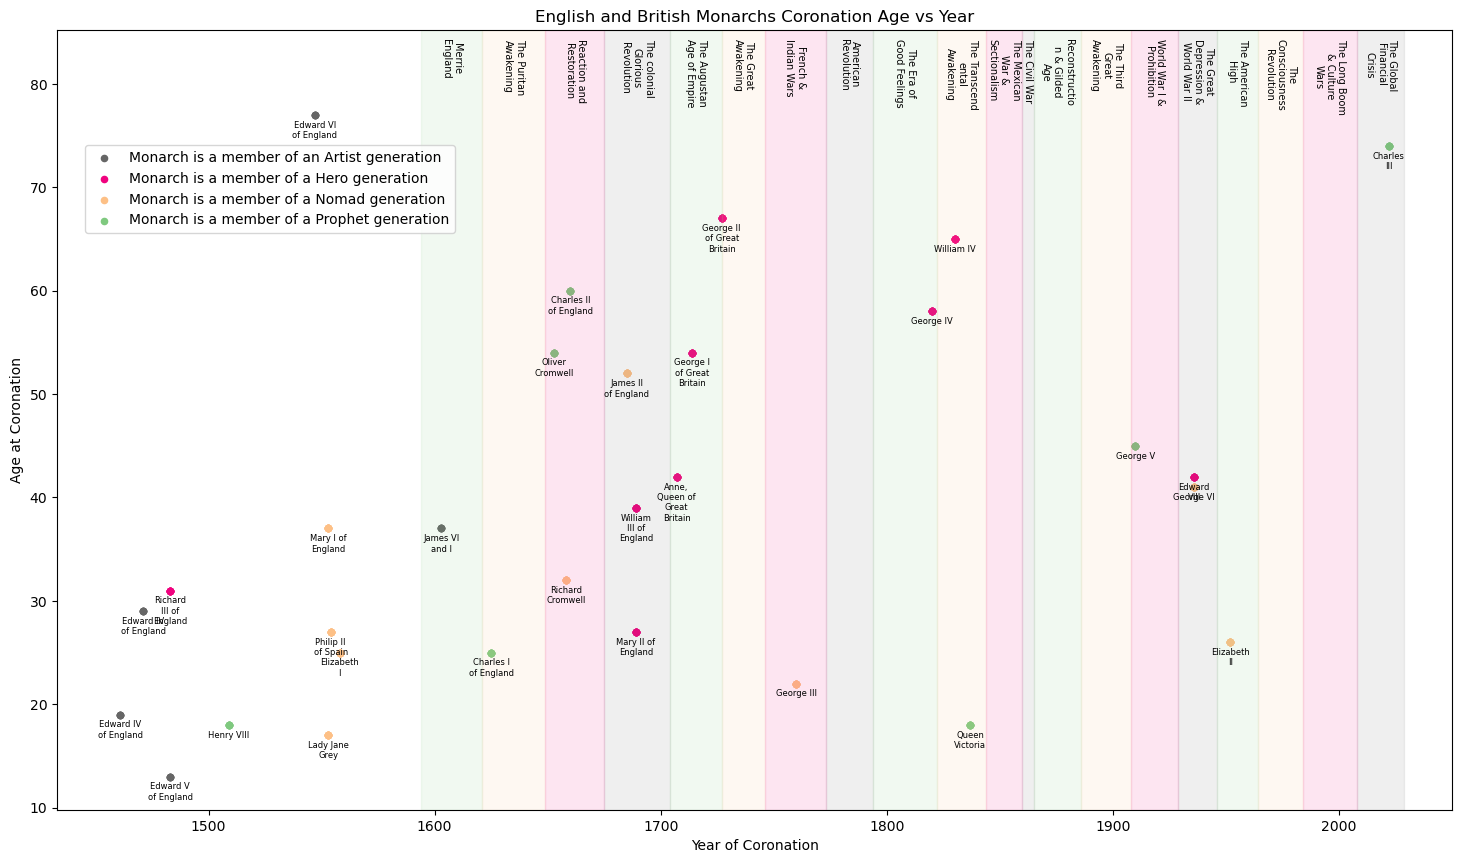

In [12]:

df1 = turnings_df.reset_index()
df2 = generations_df.reset_index()
on_list = list(set(df1.columns).intersection(set(df2.columns)))
df3 = df1.merge(df2, on=on_list)
nu.plot_inauguration_age(
    inauguration_df=english_and_british_monarchs_df, groupby_column_name='turnings_archetype', xname='year_reign_begin', leader_designation='Monarch',
    label_infix='is a member of', label_suffix='generation', info_df=df3, title_prefix='English and British Monarchs', inaugruation_verb='Coronation',
    legend_tuple=(0.02, 0.74), verbose=False
)

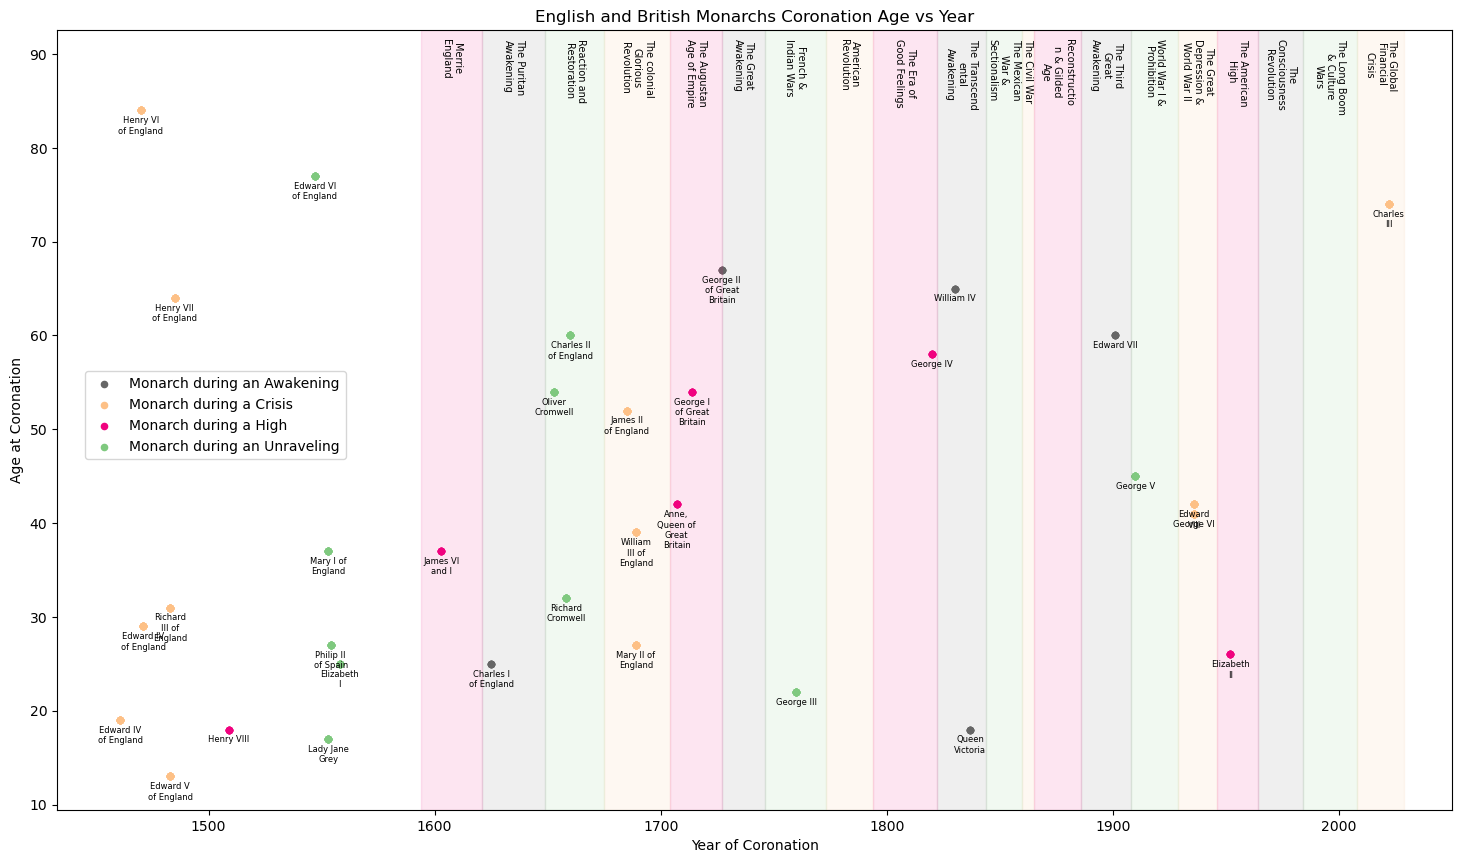

In [14]:

df1 = turnings_df.reset_index()
df2 = turning_numbers_df.reset_index().rename(columns={'index': 'turning_number'})
on_list = list(set(df1.columns).intersection(set(df2.columns)))
df3 = df1.merge(df2, on=on_list)
df4 = generations_df.reset_index()
on_list = list(set(df3.columns).intersection(set(df4.columns)))
df5 = df3.merge(df4, on=on_list)
nu.plot_inauguration_age(
    inauguration_df=english_and_british_monarchs_df, groupby_column_name='turning_type', xname='year_reign_begin', leader_designation='Monarch',
    label_infix='during', label_suffix='', info_df=df5, title_prefix='English and British Monarchs', inaugruation_verb='Coronation',
    legend_tuple=(0.02, 0.45), verbose=False
)

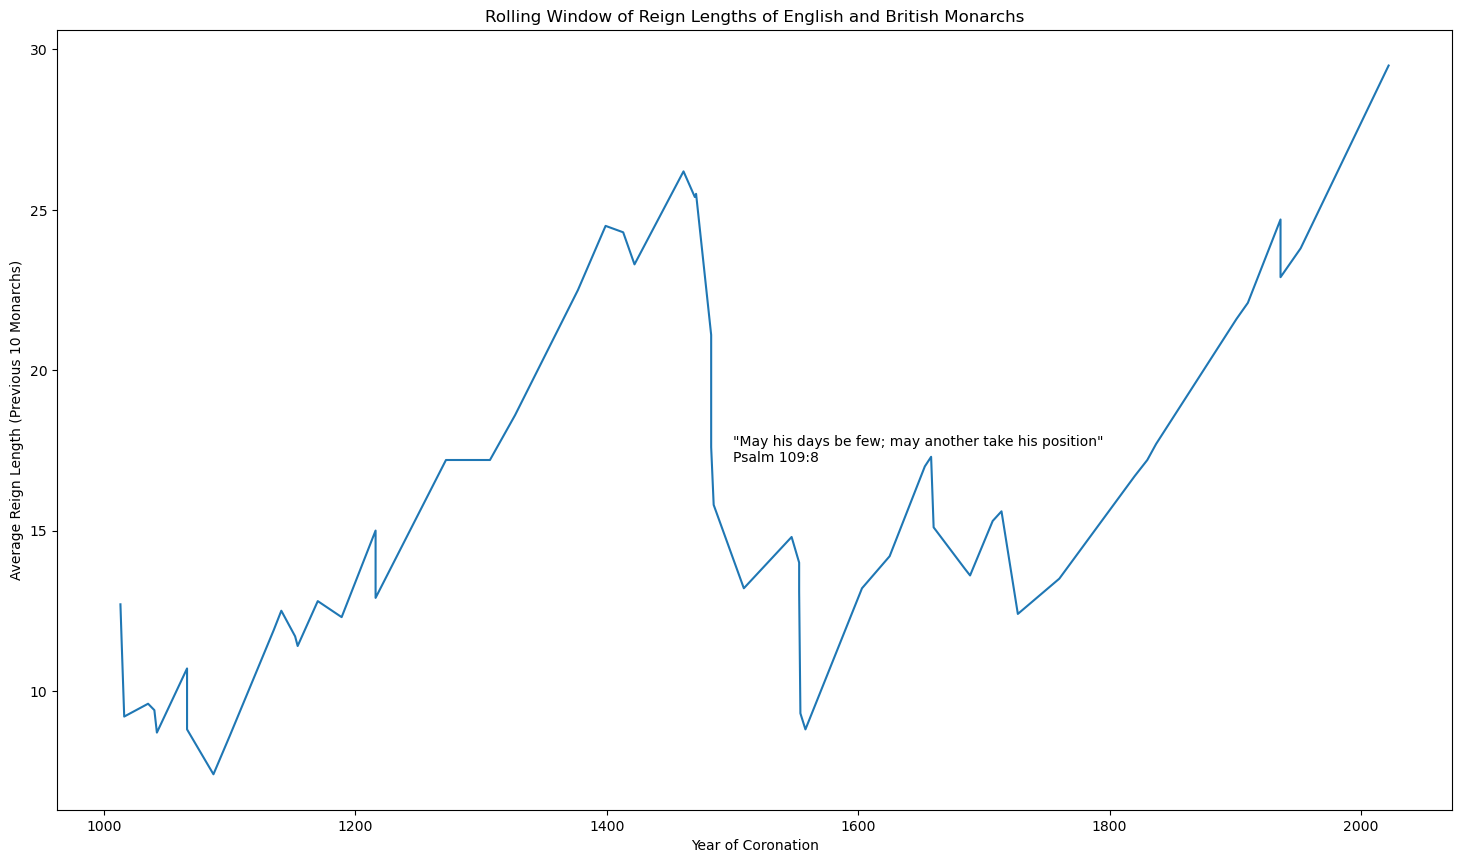

In [18]:

# Calculate the diff of the year_reign_begin column
df = english_and_british_monarchs_df.year_reign_begin.sort_values().to_frame()
df['year_reign_begin_diff'] = df.year_reign_begin.diff()

# Plot a rolling window of the year_reign_begin_diff column
figwidth = 18
fig, ax = plt.subplots(figsize=(figwidth, figwidth/nu.twitter_aspect_ratio))
ax.plot(df.year_reign_begin, df.year_reign_begin_diff.rolling(window=10).mean())

# Set the title and labels
ax.set_title('Rolling Window of Reign Lengths of English and British Monarchs')
ax.set_xlabel('Year of Coronation')
ax.set_ylabel('Average Reign Length (Previous 10 Monarchs)')

# Make a comment about the 1500s
annotation_str = '"May his days be few; may another take his position"\nPsalm 109:8'
ax.annotate(text=annotation_str, xy=(1500, 18), xytext=(1500, 18), verticalalignment='top',
            horizontalalignment='left', fontsize=10);